In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.cluster import KMeans, SpectralClustering
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap

sns.set_context(rc = {'patch.linewidth': 2.0})
sns.set_style("white")
sns.set_palette(sns.color_palette("dark"))
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('seaborn-notebook')

data_dir = '../data/'

In [2]:
df_features = pd.DataFrame.from_csv(data_dir + 'df_features.csv')

df_features = df_features[df_features.Year < 2016]
df_features.head()

,Segment_ID,Segment_Num,Year,Route,County,District,Postmile,Postmile_Boundary,Postmile_Distance,Latitude,...,Ahead_Collisions_Daytime_Ratio,Ahead_Collisions_Evening_Ratio,Ahead_Collisions_Nighttime_Ratio,Back_Collisions_Rate,Back_Collisions_Per_Distance,Back_Collisions_Morning_Ratio,Back_Collisions_Daytime_Ratio,Back_Collisions_Evening_Ratio,Back_Collisions_Nighttime_Ratio,GPS_Valid
0,0,1,2010,1,1,12,0.129,8.430,8.301,33.467051,...,0.283333,0.383333,0.216667,0.000000,6.866643,0.157895,0.228070,0.456140,0.157895,True
1,1,4,2010,1,1,12,8.430,9.418,0.988,33.531752,...,0.326923,0.480769,0.096154,0.001083,39.473684,0.051282,0.230769,0.512821,0.205128,True
2,2,5,2010,1,1,12,9.418,19.797,10.379,33.542738,...,0.355932,0.457627,0.101695,0.002472,8.575007,0.157303,0.224719,0.483146,0.134831,True
3,3,11,2010,1,1,12,19.797,21.549,1.752,33.621271,...,0.130435,0.434783,0.260870,0.000435,11.415525,0.150000,0.250000,0.400000,0.200000,True
4,4,13,2010,1,1,12,21.549,22.090,0.541,33.630667,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,True


In [5]:
for col in df_features.columns:
    print col

Segment_ID
Segment_Num
Year
Route
County
District
Postmile
Postmile_Boundary
Postmile_Distance
Latitude
Longitude
Back_Peak_Hourly
Back_Peak_Monthly
Back_AADT
Ahead_Peak_Hourly
Ahead_Peak_Monthly
Ahead_AADT
Ahead_Collisions
Back_Collisions
Total_Collisions
Ahead_Collisions_Morning
Ahead_Collisions_Daytime
Ahead_Collisions_Evening
Ahead_Collisions_Nighttime
Back_Collisions_Morning
Back_Collisions_Daytime
Back_Collisions_Evening
Back_Collisions_Nighttime
Ahead_Collision_Ratio
Back_Collision_Ratio
Ahead_Collision_Spread
Back_Collision_Spread
Ahead_Collisions_Rate
Ahead_Collisions_Per_Distance
Ahead_Collisions_Morning_Ratio
Ahead_Collisions_Daytime_Ratio
Ahead_Collisions_Evening_Ratio
Ahead_Collisions_Nighttime_Ratio
Back_Collisions_Rate
Back_Collisions_Per_Distance
Back_Collisions_Morning_Ratio
Back_Collisions_Daytime_Ratio
Back_Collisions_Evening_Ratio
Back_Collisions_Nighttime_Ratio


In [3]:
cols = [
    'Segment_ID',
    'Year',
    'Route',
    'Latitude',
    'Longitude',
    'GPS_Valid',
]

norm_cols = [    
    'Postmile_Distance', 
    'Ahead_AADT',
    'Ahead_Peak_Hourly', 
    'Ahead_Peak_Monthly', 
    'Ahead_Collisions',    
]

df_cluster = df_features[cols + norm_cols][df_features.Year == 2014]

for col in norm_cols:
    df_cluster[col].fillna(0, inplace=True)
    
    df_cluster['Norm_' + col] = df_cluster[col] / df_cluster[col].max()

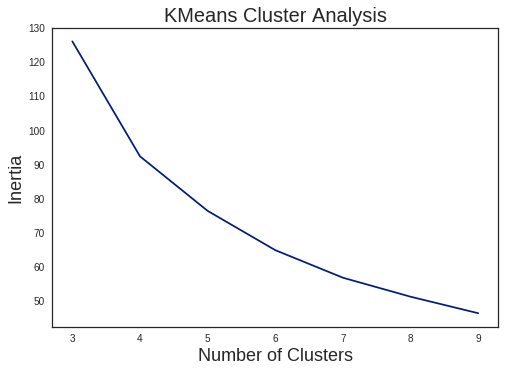

In [347]:
inertia = {}

for n in range(3, 10):
    kmeans = KMeans(n_clusters=n, max_iter=1000)
    kmeans.fit(df_cluster[['Norm_' + c for c in norm_cols]])
    
    inertia[n] = kmeans.inertia_

plt.title('KMeans Cluster Analysis', fontsize=20)
plt.xlabel('Number of Clusters', fontsize=18)
plt.ylabel('Inertia', fontsize=18)
plt.plot(inertia.keys(), [inertia[k] for k in inertia.keys()]);

In [343]:
n_clusters = 4
    
# Initialize the clusterer with n_clusters and a random seed for reproducibility.
clusterer = SpectralClustering(n_clusters=n_clusters, random_state=4,
                       assign_labels='discretize')
df_cluster['Cluster'] = clusterer.fit_predict(df_cluster[['Norm_' + c for c in norm_cols]])

colors = cm.nipy_spectral(df_cluster.Cluster.astype(float) / n_clusters)
color_list = np.unique(colors, axis=0)

df_cluster[cols + norm_cols + ['Cluster']].to_csv(data_dir + 'df_clusters_v1.0.csv')

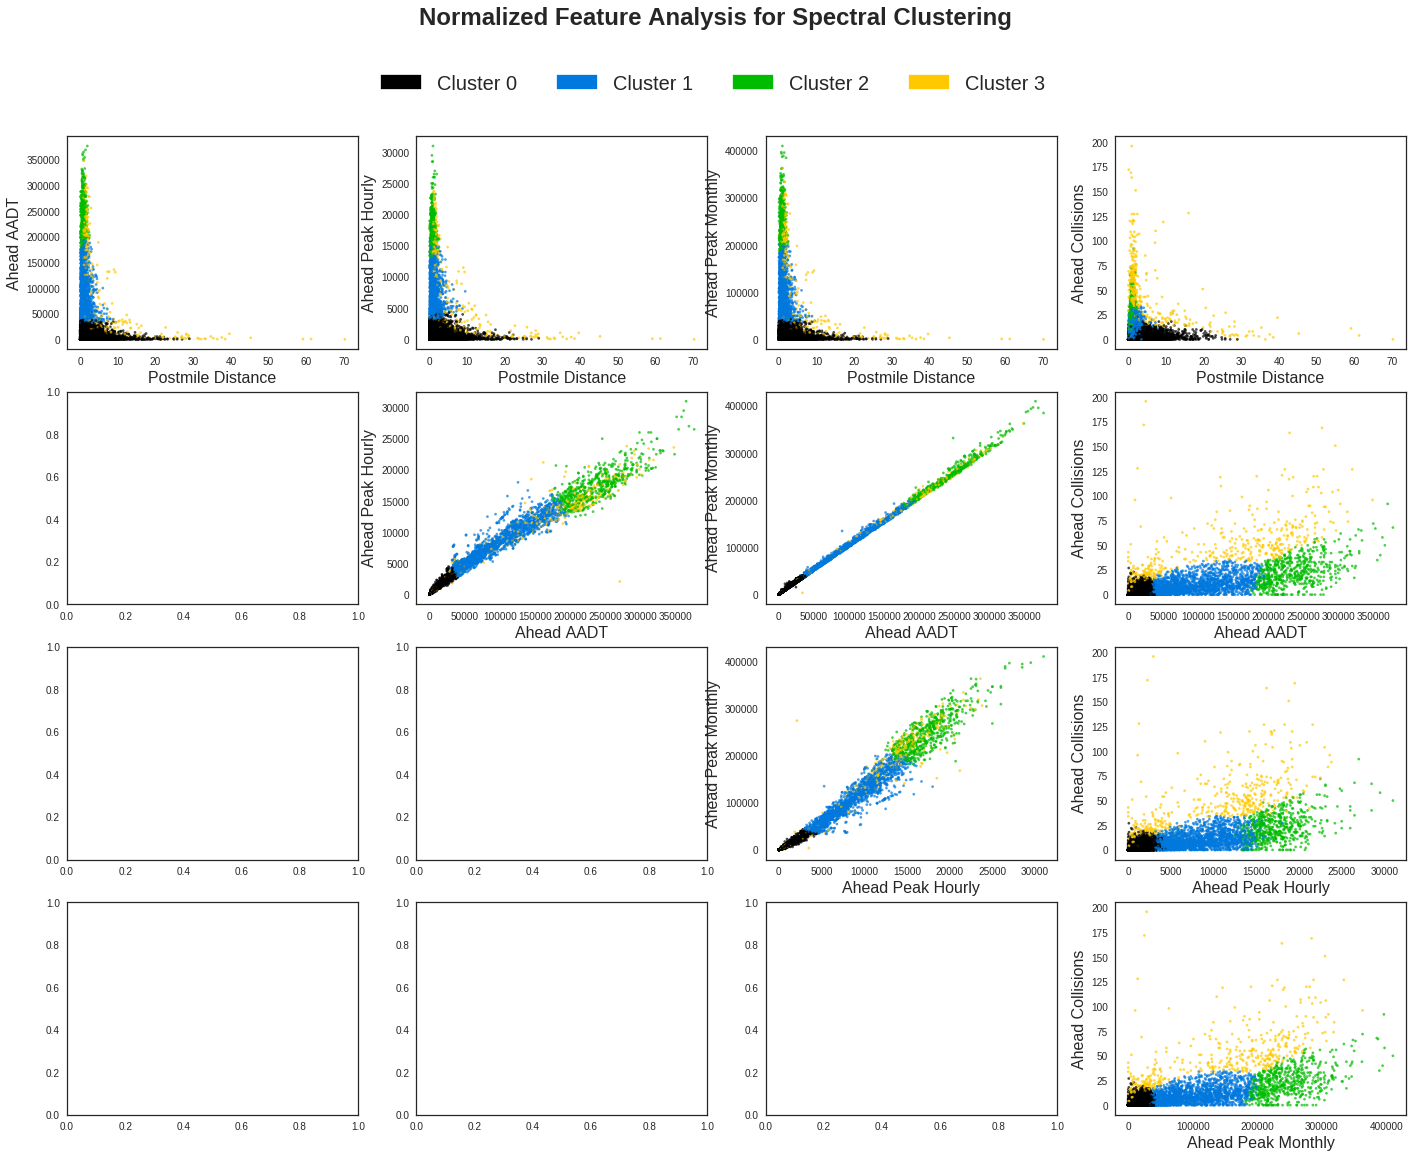

In [324]:
X = df_cluster[norm_cols]
n_cols = len(X.columns)

fig, axes = plt.subplots(n_cols - 1, n_cols - 1)
fig.set_size_inches(24, 18)

for i in range(n_cols):
    for j in range(i + 1, n_cols):
        # Colorize points using the clusters formed
        axes[i, j - 1].scatter(X.iloc[:, i], X.iloc[:, j], 
                               marker='.', s=30, lw=0, alpha=0.7, c=colors, 
                               edgecolor='k')

        axes[i, j - 1].set_xlabel(X.columns[i].replace('_', ' '), fontsize=16)
        axes[i, j - 1].set_ylabel(X.columns[j].replace('_', ' '), fontsize=16)

plt.suptitle("""Normalized Feature Analysis for Spectral Clustering""",
                     fontsize=24, fontweight='bold')

labels, patches = [], []
for i, c in enumerate(color_list):
    labels.append('Cluster %s' % i)
    patches.append(mpatches.Patch(color=c))

fig.legend(patches[:n_clusters], labels[:n_clusters], loc=2, ncol=n_clusters,
          bbox_to_anchor=(0.21, 0.85), fontsize=20)

plt.show()

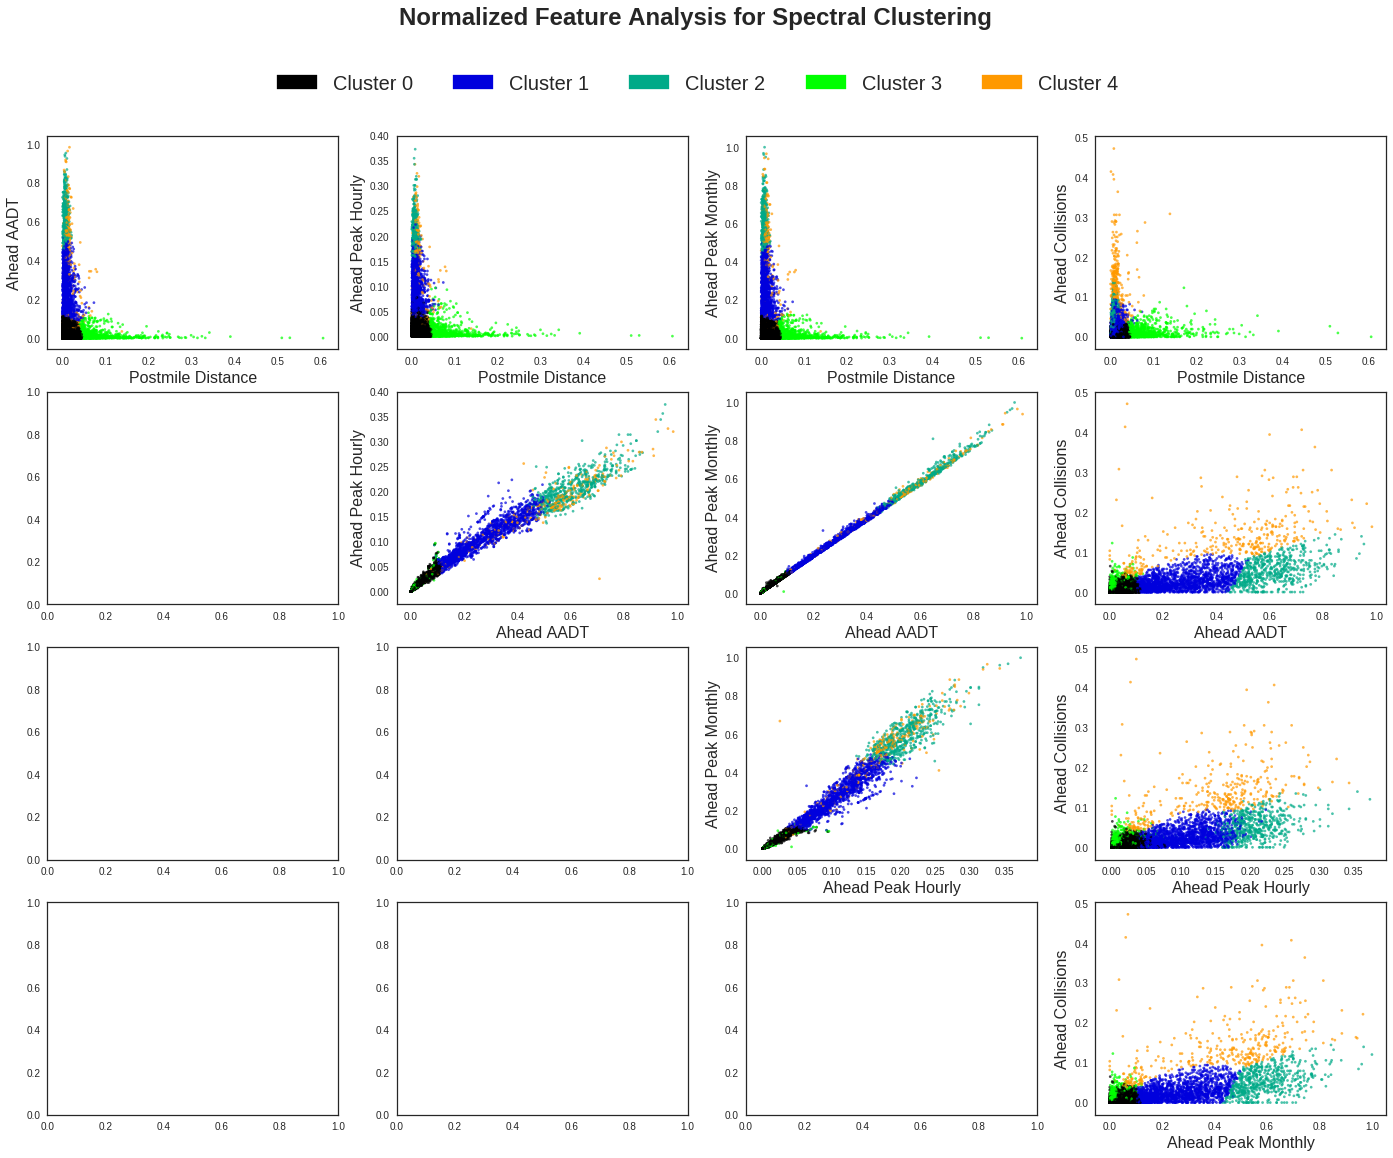

In [16]:
df_samp = df_features.sample(10, random_state=10)

df_samp.Latitude = np.round(df_samp.Latitude, 4)
df_samp.Longitude = np.round(df_samp.Longitude, 4)

show_cols = [
    'Segment_ID',
    'Year',
    'Route',
    'County',
    'Postmile',
    'Latitude',
    'Longitude',
]

print '| %s |' % ' | '.join(show_cols)
print '| %s |' % ' | '.join([str('-' * len(x)) for x in show_cols])

for i, row in df_samp.iterrows():
    print '| %s |' % ' | '.join([str(x) for x in row[show_cols].values])

| Segment_ID | Year | Route | County | Postmile | Latitude | Longitude |
| ---------- | ---- | ----- | ------ | -------- | -------- | --------- |
| 2809 | 2010 | 99 | 22 | 49.954 | 35.6827 | -119.2287 |
| 16900 | 2013 | 5 | 1 | 6.78 | 33.4671 | -117.6697 |
| 5149 | 2011 | 4 | 16 | 14.668 | 38.0059 | -122.0361 |
| 19555 | 2013 | 80 | 45 | 0.0 | 38.7217 | -121.2935 |
| 10448 | 2011 | 680 | 39 | 2.382 | 37.4956 | -121.9231 |
| 13896 | 2012 | 98 | 34 | 32.78 | 32.6792 | -115.4907 |
| 34269 | 2015 | 99 | 47 | 30.603 | 39.7148 | -121.8005 |
| 6361 | 2011 | 29 | 37 | 36.893 | 38.5753 | -122.5805 |
| 26197 | 2014 | 73 | 1 | 26.581 | 33.6733 | -117.886 |
| 13175 | 2012 | 72 | 2 | 0.96 | 33.9439 | -117.9921 |


In [17]:
show_cols = ['Segment_ID'] + norm_cols

print '| %s |' % ' | '.join(show_cols)
print '| %s |' % ' | '.join([str('-' * len(x)) for x in show_cols])

for i, row in df_samp.iterrows():
    print '| %s |' % ' | '.join([str(x) for x in row[show_cols].values])

| Segment_ID | Postmile_Distance | Ahead_AADT | Ahead_Peak_Hourly | Ahead_Peak_Monthly | Ahead_Collisions |
| ---------- | ----------------- | ---------- | ----------------- | ------------------ | ---------------- |
| 2809 | 4.521 | 51500 | 4950 | 57000 | 19 |
| 16900 | 0.564 | 234100 | 18400 | 258000 | 15 |
| 5149 | 0.756 | 88000 | 6700 | 93000 | 14 |
| 19555 | 0.268 | 180000 | 14400 | 184000 | 5 |
| 10448 | 1.633 | 136000 | 10300 | 139000 | 45 |
| 13896 | 0.14 | 22800 | 2150 | 24800 | 0 |
| 34269 | 0.895 | 52300 | 5000 | 55000 | 3 |
| 6361 | 1.009 | 8600 | 850 | 9400 | 3 |
| 26197 | 0.701 | 117200 | 8100 | 130000 | 7 |
| 13175 | 0.89 | 37000 | 3150 | 38000 | 10 |
